In [106]:
import datetime
import pandas as pd
import xgboost as xgb
from sklearn import metrics
import matplotlib.pyplot as plt
import numpy as np
import random
import math

## Data Preprocessing

In [107]:
def preprocessing(file):
    #* 讀取資料
    stock_data = pd.read_excel(file)
    stock_data = stock_data.fillna(0)
    stock_data = stock_data.drop(columns=['證券代碼', 'ReturnMean'])
    #? print(stock_data)

    #* 擷取股票年月與簡稱
    stock_year = stock_data['年月'].unique()
    stock_name = stock_data['簡稱'].unique()
    
    return stock_data

## Normalization

In [108]:
def normalization(data):
    for col in data.columns[2:-2]:
        data[col] = (data[col] - data[col].min()) / (data[col].max() - data[col].min())
        
    return data

## Split train and test by TV(2010~2015)

In [109]:
def split_train_test(stock, TV):
    #* 擷取股票年月與
    stock_year = stock['年月'].unique()
    
    basic_train_data = stock[stock['年月'].isin(stock_year[:TV])]
    train_label = basic_train_data['ReturnMean_year_Label']
    train_data = basic_train_data.drop(columns=['簡稱', '年月', 'Return', 'ReturnMean_year_Label'])

    basic_test_data = stock[stock['年月'].isin(stock_year[TV:])]
    test_label = basic_test_data['ReturnMean_year_Label']
    test_data = basic_test_data.drop(columns=['簡稱', '年月', 'Return', 'ReturnMean_year_Label'])
    
    return train_data, train_label, test_data, test_label

## Genetic Algorithm

### 染色體解碼

In [110]:
def decode(chromosome):
    dna_len = len(chromosome)
    code = 0
    for i in range(dna_len):
        gene = dna_len - i - 1
        code += chromosome[gene] * (2**i)
    
    return code

### 初始種群

In [111]:
def initial_population(pop_num, dna_length):
    population = []
    for i in range(pop_num):
        chromosome = np.ones(dna_length, np.bool8)     
        chromosome[:int(0.3 * dna_length)] = False             
        np.random.shuffle(chromosome)
        population.append(chromosome)
    # print(population)
    return population

### 適應度

In [112]:
def fitness(data, pop):
    train_data, train_label, test_data, test_label = data
    
    scores = []
    for chromosome in pop:
        attribute = chromosome[:21]
        d_train = xgb.DMatrix(train_data.values[:, attribute], label=train_label)
        d_test = xgb.DMatrix(test_data.values[:, attribute], label=test_label)
        
        param = {
            'objective':'binary:logistic',
            'learning_rate': 0.01 + decode(chromosome[21:25].astype('int8') * 0.05), # [0.01, 1] -> 4bits
            'eta': 0.01 + decode(chromosome[25:29].astype('int8') * 0.01), # [0.01, 0.2] -> 4bits 
            'max_depth': 2 + decode(chromosome[29:32].astype('int8')), # [1, 10] -> 3bits
            'min_child_weight': 0.1 + decode(chromosome[32:35].astype('int8')), # [0.01, 10.0] -> 3bits
            'gamma': 0.1 + decode(chromosome[35:39].astype('int8') * 0.5), # [0.01, 10.0] -> 4bits
            'subsample': 0.1 + decode(chromosome[39:42].astype('int8') * 0.1), # [0.01, 1] -> 3bits
            'colsample_bytree': 0.1 + decode(chromosome[42:45].astype('int8') * 0.1), # [0.01, 1] -> 3bits
            'seed': 24
        }
        model = xgb.train(param, d_train, num_boost_round=100)
        predictions = model.predict(d_test)
        predictions[predictions >= 0.5] = 1
        predictions[predictions < 0.5] = 0
        test_score = metrics.accuracy_score(test_label, predictions)
        scores.append(test_score) # 準確率
        
    scores, pop = np.array(scores), np.array(pop) 
    inds = np.argsort(scores)
    return list(pop[inds, :][::-1]), list(scores[inds][::-1])  # my_list[start(開始的index):end(結束的index):sep(間隔)]

### 選擇

In [113]:
def selection(data, pop):
    ran_F = random.choices(pop, k=2)
    ran_M = random.choices(pop, k=2)
    
    ran_F, sort_F = fitness(data, ran_F)
    ran_M, sort_M = fitness(data, ran_M)

    father = ran_F[0]
    mother = ran_M[0]

    return father, mother

### 交配

In [114]:
def cross(data, pop, cross_rate=0.7):
    pop_size, dna_len = np.array(pop).shape
    new_pop = []
    while len(new_pop) != pop_size:
        father, mother = selection(data, pop)

        if np.random.rand() < cross_rate:
            cross_point = np.random.randint(low=0, high=dna_len)
            cut_F = father[cross_point:].copy()
            cut_M = mother[cross_point:].copy()
            father[cross_point:] = cut_M
            mother[cross_point:] = cut_F
            
        new_pop.extend([father, mother])
        
    return new_pop

### 變異

In [115]:
def mutation(cross_pop, mutation_rate=0.005):
    pop_size, dna_len = np.array(cross_pop).shape
    new_pop = []
    for i in range(pop_size):
        if np.random.rand() < mutation_rate:
            mutation_point = np.random.randint(low=0, high=dna_len)
            if cross_pop[i][mutation_point] == 0:
                cross_pop[i][mutation_point] = 1
            else:
                cross_pop[i][mutation_point] = 0
                
        new_pop.append(cross_pop[i])

    return new_pop

### 分析

#### 計算種群適應度最佳值及平均值

In [116]:
def best_avg_fitness(score):
    return np.round(np.max(score), 10), np.round(np.mean(score), 10)

#### 繪製種群狀態

In [117]:
def draw_fitness(run, best_pop, avg_pop):
    plt.title("Best & Avg fitness") # 圖表標題
    plt.xlabel("Generation") # 圖表x軸標題
    plt.ylabel("fitness") # 圖表y軸標題
    plt.plot(run, best_pop, color='r', label='Best fitness', linestyle='-', marker='*') # 定義畫圖的顏色、圖例、線條、形狀、寬度
    plt.plot(run, avg_pop, color='b', label='Avg fitness', linestyle='--', marker='o') # 定義畫圖的顏色、圖例、線條、形狀、寬度
    plt.grid(axis='y') # 定義網格
    plt.legend(loc='lower right') # 當有兩種以上資料，可以使用.legend()來顯示資料的圖例
    plt.savefig('fitness_plot.png')

#### 策略

In [118]:
strategy_money = []
start_money = 10000  # 初始金額

def strategy(predict_data, TV):
    df = pd.read_excel('./top200_testing.xlsx')
    stocks_data = df.drop(['年月', 'Return', 'ReturnMean_year_Label'], axis=1)
    stocks_name = df['簡稱'].unique()
    current_stock = dict()
    for n in stocks_name:
        current_stock[n] = 0
    current_money = start_money

    # 策略
    for pre_times in range(6 - TV):
        tmp = 0
        tmp_stock = []
        for i in range(200):
            # 賣出
            if predict_data[pre_times * 200 + i] == 0:
                predict_name = stocks_data["簡稱"][(TV + pre_times) * 200 + i]
                current_money += stocks_data["收盤價(元)_年"][(TV + pre_times) * 200 + i] * current_stock[predict_name]
                current_stock[predict_name] = 0

            # 紀錄要買哪隻和每隻要分多少錢下去
            if predict_data[pre_times * 200 + i] == 1:
                tmp += 1
                tmp_stock.append(i)

        if tmp:
            per_money = current_money / tmp
            for j in tmp_stock:
                # 買入
                if stocks_data["收盤價(元)_年"][(TV + pre_times) * 200 + j] != 0:
                    predict_name = stocks_data["簡稱"][(TV + pre_times) * 200 + j]
                    current_stock[predict_name] += per_money / stocks_data["收盤價(元)_年"][(TV + pre_times) * 200 + j]

            current_money = 0

    # 折現
    for i in range(1000, 1200):
        stocks_name = stocks_data["簡稱"][i]
        current_money += current_stock[stocks_name] * stocks_data["收盤價(元)_年"][i]
        
    #* 最後一年無法折現的股票以均價計算其價值
    current_money += sum(current_stock.values()) * np.mean(stocks_data["收盤價(元)_年"])

    strategy_money.append(math.floor(current_money))

#### 計算IRR

In [119]:
def ROI():
    ROI = []
    for i in range(len(strategy_money)):
        ROI.append((strategy_money[i] - start_money) / start_money)
    return ROI

def IRR():
    IRR = []
    roi = ROI()
    for i in range(len(roi) - 1):
        IRR.append(((roi[i] + 1) ** (1 / (5 - i)) - 1) * 100)
        
    print("IRR:", IRR)

    plt.plot(IRR)
    plt.xlabel("Train_time(year)")
    plt.ylabel("Strategy IRR(%)")
    plt.show()

## Main Function

[TV1]
Best_Chromosome: [0 0 1 1 1 1 0 1 1 1 0 0 1 1 1 0 0 1 1 0 1 0 1 1 1 1 0 1 1 1 1 1 1 1 1 0 0
 1 1 1 1 1 0 1 1]
測試結果:
score: 0.578
stratedy_money:  39823
[TV2]
Best_Chromosome: [1 1 1 1 1 0 1 1 1 1 1 1 0 1 1 1 0 0 0 1 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 0 1
 1 0 0 1 0 1 1 1]
測試結果:
score: 0.60125
stratedy_money:  41151
[TV3]
Best_Chromosome: [0 1 1 1 1 1 0 1 0 0 0 1 0 1 1 1 1 1 1 1 1 0 1 1 1 0 0 1 1 1 1 0 0 0 1 1 1
 1 0 1 1 1 1 1 1]
測試結果:
score: 0.6133333333333333
stratedy_money:  35071
[TV4]
Best_Chromosome: [1 0 1 1 0 0 1 1 1 0 1 0 1 1 1 1 0 1 1 1 1 1 1 0 1 0 0 1 1 1 1 1 1 1 0 1 1
 1 0 1 0 1 0 1 0]
測試結果:
score: 0.5975
stratedy_money:  29073
[TV5]
Best_Chromosome: [1 1 1 1 1 1 1 0 1 0 0 0 1 1 1 1 1 1 1 0 0 0 1 0 1 1 1 1 0 1 1 1 1 0 1 0 1
 1 1 1 0 1 1 0 1]
測試結果:
score: 0.63
stratedy_money:  31627
IRR: [31.83380738239037, 42.42790897690163, 51.93204487753948, 70.5080643254154]


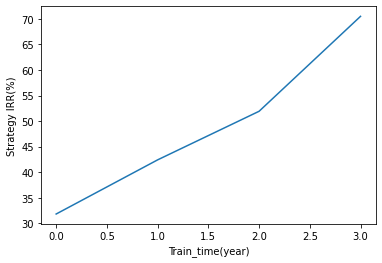

strategy_money:  [39823, 41151, 35071, 29073, 31627]


In [120]:
if __name__=="__main__":
    for TV in range(1, 6): # TV 1~5
        file_path = './top200_testing.xlsx'
        stock = preprocessing(file_path)
        normalized_stock = normalization(stock)
        train_data, train_label, test_data, test_label = split_train_test(normalized_stock, TV)
        #* Remap the labels
        train_label = train_label.map({-1:0, 1:1})
        test_label = test_label.map({-1:0, 1:1})
        
        data = [train_data, train_label, test_data, test_label]
        
        #* 設定GA參數
        POP_SIZE = 80 # 種群大小
        DNA_LEN = 45 # 染色體長度: 21個特徵、24個參數
        
        cross_rate = 0.7 # 交配機率
        mutation_rate = 0.001 # 變異機率
        
        #* 初始種群
        pop = initial_population(POP_SIZE, DNA_LEN)

        #* 迭代次數
        generation_num = 30
        
        #* early stopping
        overfit_num = 0
        
        i = 0
        best_fitness_list = []
        avg_fitness_list = []
        run = []
        while overfit_num < 3 and i < generation_num: # best fitness & average fitness 連續相等5次則中斷
            # print(f"[Generation {i + 1}]")
            cross_pop = cross(data, pop, cross_rate) # 選擇 -> 交配
            mutation_pop = mutation(cross_pop, mutation_rate) # 變異
            pop = mutation_pop
            i += 1
            
            pop, score = fitness(data, pop)
            # print(f"Best chromosome: {pop[0]}")
            best_fitness, average_fitness = best_avg_fitness(score)
            # print(f"Best fitness: {best_fitness}")
            # print(f"Avg fitness: {average_fitness}\n")
            best_fitness_list.append(best_fitness)
            avg_fitness_list.append(average_fitness)
            run.append(i + 1)
            
            #* early stopping
            if best_fitness == average_fitness:
                overfit_num += 1
            else:
                overfit_num = 0
            
        print(f"[TV{TV}]")
        best_chromosome = pop[0]
        print(f"Best_Chromosome: {best_chromosome.astype('int8')}")
        
        #! test result
        print(f"測試結果:")
        attribute = best_chromosome[:21]
        d_train = xgb.DMatrix(train_data.values[:, attribute], label=train_label)
        d_test = xgb.DMatrix(test_data.values[:, attribute], label=test_label)
            
        param = {
            'objective':'binary:logistic',
            'learning_rate': 0.01 + decode(best_chromosome[21:25].astype('int8') * 0.05), # [0.01, 1] -> 4bits
            'eta': 0.01 + decode(best_chromosome[25:29].astype('int8') * 0.01), # [0.01, 0.2] -> 4bits 
            'max_depth': 2 + decode(best_chromosome[29:32].astype('int8')), # [1, 10] -> 3bits
            'min_child_weight': 0.1 + decode(best_chromosome[32:35].astype('int8')), # [0.01, 10.0] -> 3bits
            'gamma': 0.1 + decode(best_chromosome[35:39].astype('int8') * 0.5), # [0.01, 10.0] -> 4bits
            'subsample': 0.1 + decode(best_chromosome[39:42].astype('int8') * 0.1), # [0.01, 1] -> 3bits
            'colsample_bytree': 0.1 + decode(best_chromosome[42:45].astype('int8') * 0.1), # [0.01, 1] -> 3bits
            'seed': 24
        }
        test_model = xgb.train(param, d_train, num_boost_round=100)
        
        #* predict label
        predictions = test_model.predict(d_test)
        predictions[predictions >= 0.5] = 1
        predictions[predictions < 0.5] = 0
        # print(predictions)
        
        #* test accuracy
        test_score = metrics.accuracy_score(test_label, predictions)
        print(f"score: {test_score}")
        
        strategy(predictions, TV)
        print('stratedy_money: ', strategy_money[TV - 1])
        
        #! fitness picture
        # draw_fitness(run, best_fitness_list, avg_fitness_list)
        
    IRR()
    print('strategy_money: ', strategy_money)